In [54]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# --- Load Data ---
patients = pd.read_csv('patients.csv')
conditions = pd.read_csv('conditions.csv')
observations = pd.read_csv('observations.csv')

In [55]:
print(f"Total patients: {len(patients)}")

Total patients: 1163


In [56]:
# --- Compute AGE ---
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients = patients[patients['DEATHDATE'].isna()].reset_index(drop=True)
reference_date = pd.to_datetime("2025-01-01")
patients['AGE'] = (reference_date - patients['BIRTHDATE']).dt.days // 365


In [57]:
# --- Diabetes/Prediabetes Outcome ---
diabetes_codes = ["44054006", "15777000"]
diabetes_patients = conditions[conditions['CODE'].astype(str).str.strip().isin(diabetes_codes)]['PATIENT'].unique()
patients['diabetes_outcome'] = patients['Id'].isin(diabetes_patients).astype(int)

In [58]:
# --- Hypertension Indicator ---
hypertension_patients = conditions[conditions['CODE'].astype(str).str.strip() == "59621000"]['PATIENT'].unique()
patients['hypertension'] = patients['Id'].isin(hypertension_patients).astype(int)

In [59]:
# --- BMI Extraction (LOINC 39156-5) ---
bmi_obs = observations[observations['CODE'] == '39156-5'].sort_values(by=['PATIENT','DATE'], ascending=[True, False])
bmi_latest = bmi_obs.groupby('PATIENT').first().reset_index()[['PATIENT','VALUE']]
bmi_latest.rename(columns={'VALUE':'BMI'}, inplace=True)

In [60]:
# --- Merge BMI and keep all patients ---
patients = patients.merge(bmi_latest, left_on='Id', right_on='PATIENT', how='left').drop(columns=['PATIENT'])
patients['BMI'] = pd.to_numeric(patients['BMI'], errors='coerce')
patients['BMI'].fillna(patients['BMI'].mean(), inplace=True)

/var/folders/hc/0c4gjvbj0939ylqy16hjn8dw0000gn/T/ipykernel_37085/3704554811.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  patients['BMI'].fillna(patients['BMI'].mean(), inplace=True)


In [61]:
# --- Logistic Regression ---
patients['GENDER'] = patients['GENDER'].fillna('Unknown')
logit_model = smf.logit('diabetes_outcome ~ AGE + BMI + hypertension + C(GENDER)', data=patients).fit(disp=0)
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:       diabetes_outcome   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.2387
Time:                        00:38:58   Log-Likelihood:                -459.75
converged:                       True   LL-Null:                       -603.93
Covariance Type:            nonrobust   LLR p-value:                 3.498e-61
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.0003      0.731     -8.203      0.000      -7.434      -4.567
C(GENDER)[T.M]     0.2541      0.163      1.556      0.120      -0.066       0.574
AGE                0.0515      0.005

In [62]:
# --- Odds Ratios and 95% CI ---
params = logit_model.params
conf = logit_model.conf_int()
odds_ratios = np.exp(params)
conf_lower = np.exp(conf[0])
conf_upper = np.exp(conf[1])
print("\nOdds Ratios and 95% CI:")
for var in odds_ratios.index:
    print(f"{var}: OR = {odds_ratios[var]:.2f}, 95% CI = [{conf_lower[var]:.2f}, {conf_upper[var]:.2f}], p = {logit_model.pvalues[var]:.3f}")


Odds Ratios and 95% CI:
Intercept: OR = 0.00, 95% CI = [0.00, 0.01], p = 0.000
C(GENDER)[T.M]: OR = 1.29, 95% CI = [0.94, 1.78], p = 0.120
AGE: OR = 1.05, 95% CI = [1.04, 1.06], p = 0.000
BMI: OR = 1.10, 95% CI = [1.04, 1.15], p = 0.000
hypertension: OR = 1.03, 95% CI = [0.73, 1.46], p = 0.862


In [63]:
# --- Summary Counts ---
print(f"\nTotal patients: {len(patients)}")
print(f"Patients with diabetes/prediabetes: {patients['diabetes_outcome'].sum()}")
print(f"Patients with hypertension: {patients['hypertension'].sum()}")


Total patients: 1000
Patients with diabetes/prediabetes: 292
Patients with hypertension: 252


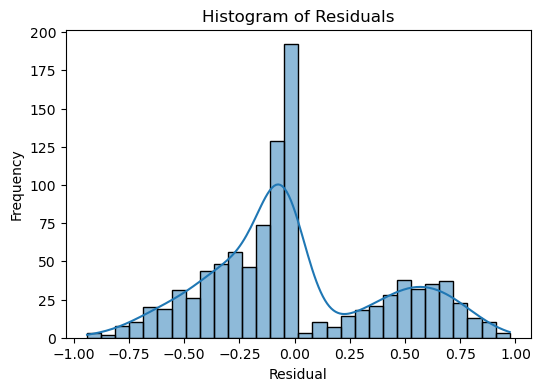

In [64]:
# --- Histogram of Residuals ---
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [65]:
# --- VIF Check ---
X = patients[['AGE','BMI','hypertension']].copy()
X = sm.add_constant(X)
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_df)


Variance Inflation Factors:
       Variable        VIF
0         const  34.059878
1           AGE   1.541564
2           BMI   1.549632
3  hypertension   1.070088


Interpretation of Logistic Regression Results
This table summarizes the results of a logistic regression predicting the probability of diabetes or prediabetes outcome using age, BMI, gender, and hypertension status.

Key Points
Pseudo R-squared = 0.239:
The model explains about 23.9% of the variance in diabetes outcome, which is relatively strong for healthcare prediction models using limited demographic and clinical features.

AGE (coef = 0.0515, p < 0.001):

For each additional year of age, the log odds of having diabetes increase by 0.0515.

In odds ratio terms: exp(0.0515) ≈ 1.053.

This means each additional year of age increases the odds of having diabetes by about 5.3%, holding other variables constant.

This effect is statistically significant (p < 0.001).

BMI (coef = 0.0917, p < 0.001):

For each one-unit increase in BMI, the log odds of having diabetes increase by 0.0917.

In odds ratio terms: exp(0.0917) ≈ 1.096.

This means each unit increase in BMI increases the odds of having diabetes by about 9.6%, holding other variables constant.

This effect is statistically significant (p < 0.001).

Hypertension (coef = 0.0308, p = 0.862):

Having hypertension is associated with only a 3.1% increase in the odds of diabetes (exp(0.0308) ≈ 1.031).

This effect is not statistically significant (p > 0.05).

Gender (Male vs. Female) (coef = 0.2541, p = 0.120):

Being male is associated with a 28.9% increase in the odds of diabetes compared to females (exp(0.2541) ≈ 1.289).

However, this effect is not statistically significant (p > 0.05).

Additional Notes
Intercept (-6.0003): Represents the baseline log odds of diabetes when all predictors are at zero (not directly meaningful in practice).

Model Fit:

Pseudo R-squared (0.239) indicates a relatively strong explanatory power for a health outcome model.

LLR p-value (< 0.001) shows that the overall model is significantly better than a null (no-predictor) model.

Summary
Among these predictors, age and BMI are significant risk factors for diabetes, with BMI having a substantial impact on diabetes risk. Gender and hypertension are not significant predictors in this dataset.
